## DATA SCIENCE SALARIES 2023

### Import Libraries

In [1]:
import kaggle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pycountry
from fuzzywuzzy import process
from wordcloud import WordCloud

In [2]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('arnabchaki/data-science-salaries-2023', path='./', unzip=True)


## Exploratory Data Analysis

In [3]:
salary_df = pd.read_csv("ds_salaries.csv")

In [4]:
salary_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [5]:
salary_df.info

<bound method DataFrame.info of       work_year experience_level employment_type                 job_title  \
0          2023               SE              FT  Principal Data Scientist   
1          2023               MI              CT               ML Engineer   
2          2023               MI              CT               ML Engineer   
3          2023               SE              FT            Data Scientist   
4          2023               SE              FT            Data Scientist   
...         ...              ...             ...                       ...   
3750       2020               SE              FT            Data Scientist   
3751       2021               MI              FT  Principal Data Scientist   
3752       2020               EN              FT            Data Scientist   
3753       2020               EN              CT     Business Data Analyst   
3754       2021               SE              FT      Data Science Manager   

       salary salary_currency  

In [6]:
salary_df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [7]:
# change work year into datetime format
salary_df = salary_df.rename(columns={"work_year" : "year"})

In [8]:
salary_df["year"] = pd.to_datetime(salary_df["year"], format="%Y").dt.year

In [9]:
# change symbols for better understanding
salary_df["experience_level"] = salary_df["experience_level"].replace("EN", "Entry Level") 
salary_df["experience_level"] = salary_df["experience_level"].replace("MI", "Junior") 
salary_df["experience_level"] = salary_df["experience_level"].replace("SE", "Senior ") 
salary_df["experience_level"] = salary_df["experience_level"].replace("EX", "Executive/Director") 

In [10]:
employment_type_dict = {
    "FT" : "Full Time",
    "CT" : "Contract",
    "FL" : "Seasonal",
    "PT" : "Part Time"
}

# using map instead of replace
salary_df["employment_type"] = salary_df["employment_type"].map(employment_type_dict)
salary_df.head()

,year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior,Full Time,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,Junior,Contract,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,Junior,Contract,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,Senior,Full Time,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,Senior,Full Time,Data Scientist,120000,USD,120000,CA,100,CA,M


In [11]:
# change country code to country name
def get_country_name(code) :
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return "Unknown"

In [12]:
salary_df["company_location"] = salary_df["company_location"].apply(get_country_name)
salary_df['company_location']

0               Spain
1       United States
2       United States
3              Canada
4              Canada
            ...      
3750    United States
3751    United States
3752    United States
3753    United States
3754            India
Name: company_location, Length: 3755, dtype: object

In [13]:
salary_df["job_title"].unique()

array(['Principal Data Scientist', 'ML Engineer', 'Data Scientist',
       'Applied Scientist', 'Data Analyst', 'Data Modeler',
       'Research Engineer', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Machine Learning Engineer',
       'Data Strategist', 'Data Engineer', 'Computer Vision Engineer',
       'Data Quality Analyst', 'Compliance Data Analyst',
       'Data Architect', 'Applied Machine Learning Engineer',
       'AI Developer', 'Research Scientist', 'Data Analytics Manager',
       'Business Data Analyst', 'Applied Data Scientist',
       'Staff Data Analyst', 'ETL Engineer', 'Data DevOps Engineer',
       'Head of Data', 'Data Science Manager', 'Data Manager',
       'Machine Learning Researcher', 'Big Data Engineer',
       'Data Specialist', 'Lead Data Analyst', 'BI Data Engineer',
       'Director of Data Science', 'Machine Learning Scientist',
       'MLOps Engineer', 'AI Scientist', 'Autonomous Vehicle Technician',
       'Applied Machine Learning Sc

In [14]:
unique_titles = []
title_mapping = {}

def replace_titles(title) :
    if unique_titles:
        closest_match, score = process.extractOne(title, unique_titles)
        
        if score < 90 :
            unique_titles.append(title)
            title_mapping[title] = title
            return title
        else:
            title_mapping[title] = closest_match
            return closest_match
    else :
        unique_titles.append(title)
        title_mapping[title] = title
        return title
        
salary_df["job_title"] = salary_df["job_title"].apply(replace_titles)

## Analysis and Visualizations

### 1. What is the average salary of data science jobs in a specific geographic location?


In [15]:
salary_per_location = salary_df.groupby("company_location")["salary_in_usd"].agg(lambda x : round(np.mean(x), 2))
salary_per_location = salary_per_location.sort_values(ascending=False).reset_index()

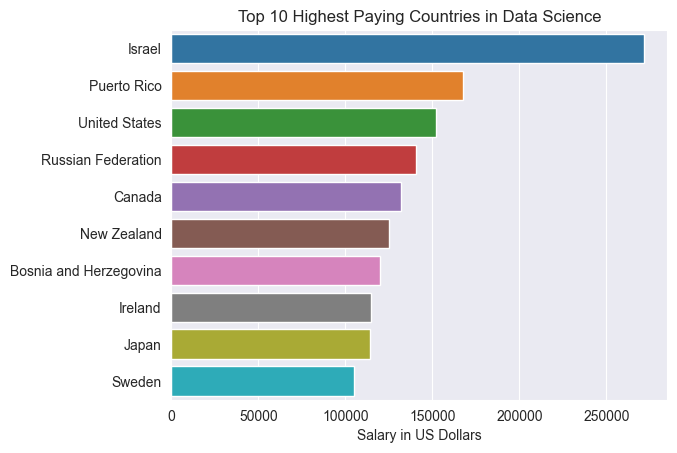

In [16]:
sns.set_style("darkgrid")
sns.barplot(x = "salary_in_usd", y = "company_location", data=salary_per_location.head(10))

plt.xlabel("Salary in US Dollars")
plt.ylabel("")
plt.title("Top 10 Highest Paying Countries in Data Science")
plt.show()

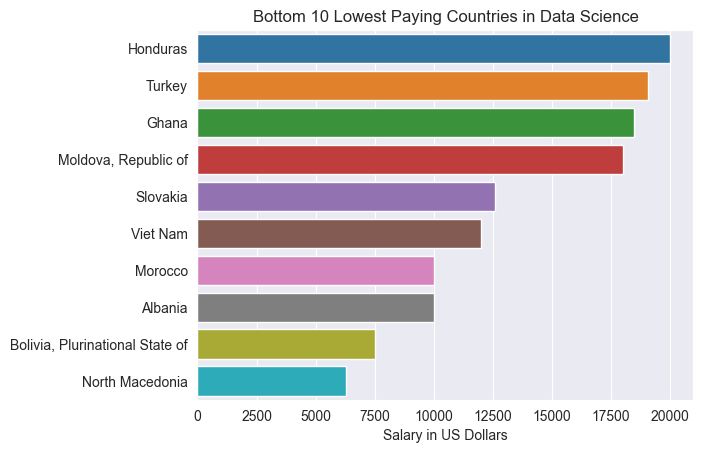

In [17]:
sns.set_style("darkgrid")
sns.barplot(x = "salary_in_usd", y = "company_location", data=salary_per_location.tail(10))

plt.xlabel("Salary in US Dollars")
plt.ylabel("")
plt.title("Bottom 10 Lowest Paying Countries in Data Science")
plt.show()

### 

We found that Isreal has the highest average salary in data science of \$ 270,000, followed by the United States at around \$ 160,000. This suggests that these countries value the field of data science and its applications. The high average salary in Isreal indicates a strong emphasis on data science as a critical field for driving innovation, economic growth and technological advances. 

The higher average salaries in these countries suggests that they recongnize the importance of attracting and retaining talents in this field. 

### 2. What are the most common job titles in the field of data science, and how do their salaries differ?


In [18]:
job_count = salary_df["job_title"].value_counts().reset_index()

In [19]:
job_count.columns = ["job_title", "count"]

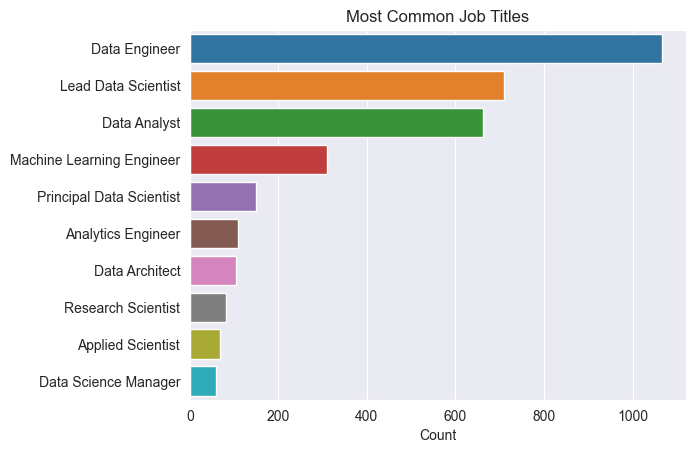

In [20]:
sns.barplot(x = "count",
            y = "job_title", 
            data = job_count.head(10))

plt.title("Most Common Job Titles")
plt.xlabel("Count")
plt.ylabel("")
plt.show()

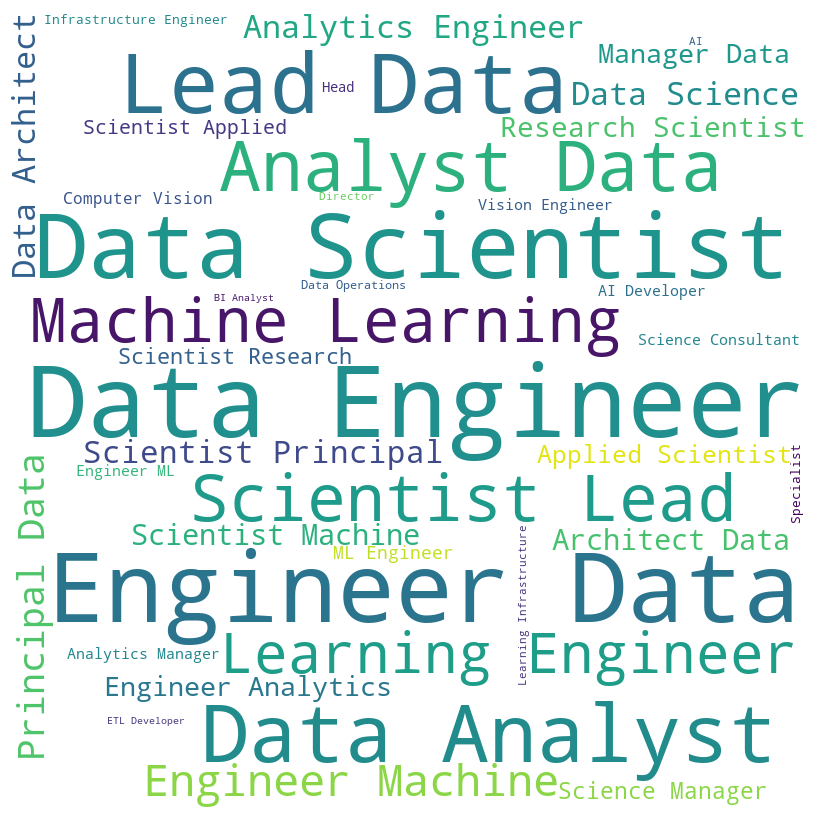

In [26]:
text = ' '.join(title for title in salary_df.job_title)

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = None,
                      min_font_size = 10).generate(text)

# Plot the WordCloud image                    
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [21]:
salary_per_title = salary_df.groupby("job_title")["salary_in_usd"].agg(lambda x : round(np.mean(x), 2))
salary_per_title = salary_per_title.sort_values(ascending=False).reset_index()

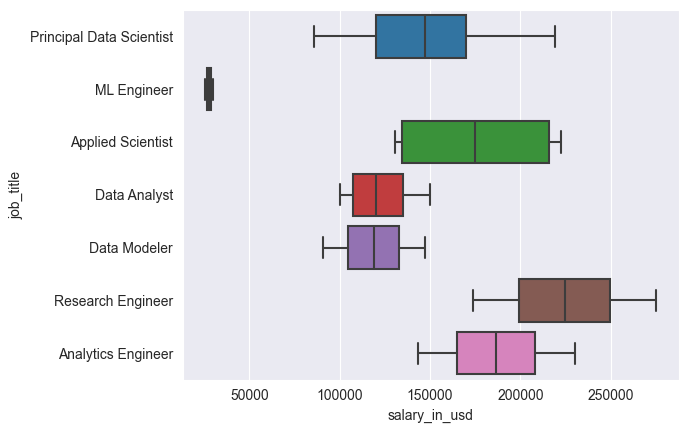

In [25]:
sns.boxplot(y = "job_title", x = "salary_in_usd", data = salary_df.head(25))

plt.show()

###
The most common job title in this dataset is the Principal Data Scientist with 2000 counts. Followed by Compliance Data Analyst and Machine Learning Engineer with 550 counts. In the next plot, we can observe the salary ranges for different job titles, with Princial Data Scientist with the most outliers above the max interquartile range meaning this position get a higher salary in USD, on average, compared to the rest of the positions.

3. What is the distribution of salaries among entry-level, mid-level, and senior data science positions?



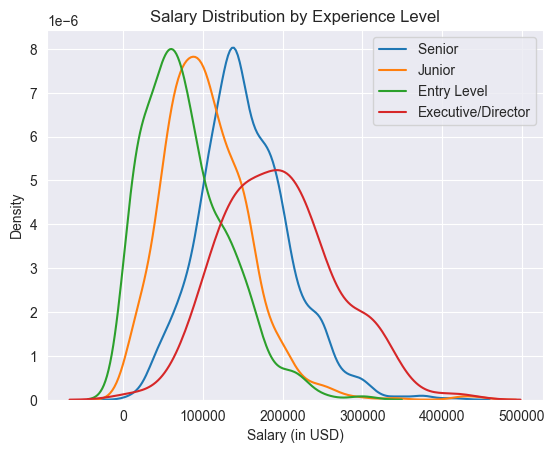

In [23]:
for level in salary_df["experience_level"].unique() :
    sns.kdeplot(salary_df[salary_df["experience_level"] == level]["salary_in_usd"], label = level)

plt.xlabel('Salary (in USD)')
plt.ylabel('Density')
plt.title('Salary Distribution by Experience Level')
plt.legend()
plt.show()

4. How does the size of the company (small, medium, large) impact the salaries of data science professionals?



5. What is the average salary growth rate for data scientists over the past few years?


6. How does the salary of data science managers compare to individual contributors?


7. Are there any regional variations in data science salaries within a country or across different countries?


8. Is there a difference in salaries based on the type of employment (full-time, part-time, contract) in data science?
